In [1]:
import pickle

from pyboost import controllers as pb
from pyspark import SparkContext


sc = SparkContext(master="local[3]")
# sc = SparkContext(master=master_url, pyFiles=["dist/pyboost-0.1-py2.7.egg"])
sc.setCheckpointDir('checkpoint/')

In [2]:
import pickle

X_train, X_test, y_train, y_test = pickle.load(open("../experiments/higgs/data/higgs-data-1p.pickle"))
# X_train, X_test, y_train, y_test = pickle.load(open("../../higgs-data-1p.pickle"))
y_train = [y + y - 1 for y in y_train]
y_test = [y + y - 1 for y in y_test]

In [3]:
X = sc.parallelize(X_train)
y = sc.parallelize(y_train)

In [4]:
num_round = 1000

In [5]:
adaboost = pb.run_adtree_adaboost(sc, y, X, T=num_round, quiet=False)

=== Iteration 1 ===
Min score: 0.967118633849
Purity (farther from 1.0 is better): (1.3052988716944389, 0.47728705697035173)
Predicts (farther from 0.0 is better): (0.13321601750449216, -0.36981858625859865)
Split node: 0 (left)
Split index and value: 25 1.1076529026 

=== Iteration 2 ===
Min score: 0.98316527691
Purity (farther from 1.0 is better): (0.66859705334231379, 1.3860486629931645)
Predicts (farther from 0.0 is better): (-0.20128685610574179, 0.16322850526801749)
Split node: 1 (left)
Split index and value: 25 0.738965153694 

=== Iteration 3 ===
Min score: 0.988463402842
Purity (farther from 1.0 is better): (0.46245733677688566, 1.2503552521285859)
Predicts (farther from 0.0 is better): (-0.38560048554560233, 0.1117138563197123)
Split node: 2 (right)
Split index and value: 26 0.833097785711 

=== Iteration 4 ===
Min score: 0.985341652558
Purity (farther from 1.0 is better): (1.3293505658224798, 0.73817551560065175)
Predicts (farther from 0.0 is better): (0.14234526330204483, -

In [5]:
logitboost = pb.run_adtree_logitboost(sc, y, X, T=num_round, quiet=False)

=== Iteration 1 ===
Min score: 0.968636308223
Purity (farther from 1.0 is better): (1.4299846761626092, 0.567108230997308)
Predicts (farther from 0.0 is better): (0.17883186412209806, -0.28360255493860209)
Split node: 0 (left)
Split index and value: 25 1.02104735374 

=== Iteration 2 ===
Min score: 0.983863124869
Purity (farther from 1.0 is better): (0.64294869251920361, 1.6487049264857367)
Predicts (farther from 0.0 is better): (-0.22084517591651809, 0.24999504334186298)
Split node: 1 (left)
Split index and value: 25 0.640890270472 

=== Iteration 3 ===
Min score: 0.984899594849
Purity (farther from 1.0 is better): (0.83299967641614936, 0.27164647736075537)
Predicts (farther from 0.0 is better): (-0.091361012635686495, -0.65162688681723324)
Split node: 1 (right)
Split index and value: 25 2.13448381424 

=== Iteration 4 ===
Min score: 0.984402749609
Purity (farther from 1.0 is better): (0.60699397297438074, 1.5854623873404501)
Predicts (farther from 0.0 is better): (-0.2496182085869711

In [6]:
import pickle

# pickle.dump(adaboost, open("adaboost.pkl", 'w'))
pickle.dump(logitboost, open("logitboost.pkl", 'w'))

In [4]:
adaboost = pickle.load(open("result/adaboost.pkl"))
logitboost = pickle.load(open("result/logitboost.pkl"))

# Performance

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from pyboost.adtree import run_tree
from pyboost.utils import safe_comp

def test_error(nodes, y, X, max_index=None):    
    error = 0
    margin = 0.0
    for tX, ty in zip(X, y):
        _m = run_tree(0, nodes, tX, max_index=max_index)
        predict = safe_comp(_m)
        if safe_comp(predict, ty):
            error += 1
        margin += _m * ty
    return 1.0 - float(error) / len(y), margin / len(y)


def test_all(nodes):
    train_accuracy, train_margin = test_error(nodes, y_train, X_train)
    test_accuracy, test_margin = test_error(nodes, y_test, X_test)
    print "Train accuracy:", train_accuracy, '\t',
    print "Train margin:", train_margin
    print "Test accuracy:", test_accuracy, '\t',
    print "Test margin:", test_margin


def test_margin(nodes):
    for max_index in range(len(nodes) + 1):
        accuracy, margin = test_error(nodes, y_train, X_train, max_index=max_index)
        print max_index, accuracy, margin


def test_improve(nodes):
    accuracy_train = []
    accuracy_test = []
    auc_train = []
    auc_test = []

    raw_y_train_pred = [0.0] * len(y_train)
    y_train_pred = [None] * len(y_train)
    raw_y_test_pred = [0.0] * len(y_test)
    y_test_pred = [None] * len(y_test)
    for i in range(len(nodes)):
        print '.',
        # Update predicts
        for idx, x in enumerate(X_train):
            raw_y_train_pred[idx] += nodes[i].predict(x, pre_check=False)
            y_train_pred[idx] = safe_comp(raw_y_train_pred[idx])
        for idx, x in enumerate(X_test):
            raw_y_test_pred[idx] += nodes[i].predict(x, pre_check=False)
            y_test_pred[idx] = safe_comp(raw_y_test_pred[idx])
        # Update train scores
        accuracy_train.append(accuracy_score(y_train, y_train_pred))
        auc_train.append(roc_auc_score(y_train, y_train_pred))
        # Update test scores
        accuracy_test.append(accuracy_score(y_test, y_test_pred))
        auc_test.append(roc_auc_score(y_test, y_test_pred))
    return (accuracy_train, auc_train), (auc_train, auc_test)

## Performance of AdaBoost

In [36]:
(accuracy_train, auc_train), (accuracy_test, auc_test) = test_improve(adaboost)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [37]:
pickle.dump(((accuracy_train, auc_train), (accuracy_test, auc_test)), open("result/adaboost_trend.pkl", 'w'))

In [57]:
(accuracy_train, auc_train), (accuracy_test, auc_test) = pickle.load(open("result/adaboost_trend.pkl"))

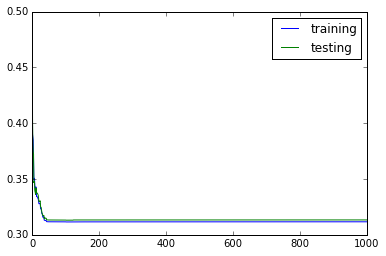

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt

f = lambda ts: map(lambda t: 1.0 - t, ts)
plt.plot(f(accuracy_train[:]), label="training")
plt.plot(f(accuracy_test[:]), label="testing")
plt.legend()

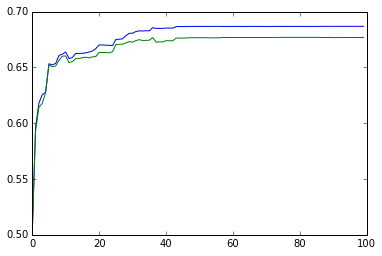

In [41]:
plt.plot(auc_train[:100])
plt.plot(auc_test[:100])

In [58]:
print "Test accuracy:", "%.2f" % (accuracy_test[-1] * 100) + '%'

Test accuracy: 68.67%


# Performance of LogitBoost

In [ ]:
(accuracy_train, auc_train), (accuracy_test, auc_test) = test_improve(logitboost)

In [ ]:
# (accuracy_train, auc_train), (accuracy_test, auc_test) = pickle.load(open("result/logitboost_trend.pkl"))

In [ ]:
import pickle
pickle.dump(((accuracy_train, auc_train), (accuracy_test, auc_test)), open("result/logitboost_trend.pkl", 'w'))

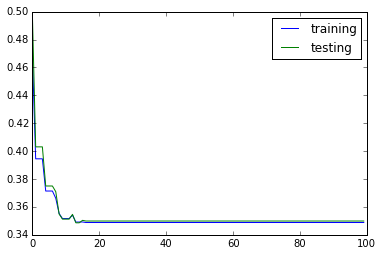

In [44]:
%matplotlib inline
from matplotlib import pyplot as plt

f = lambda ts: map(lambda t: 1.0 - t, ts)
plt.plot(f(accuracy_train[:100]), label="training")
plt.plot(f(accuracy_test[:100]), label="testing")
plt.legend()

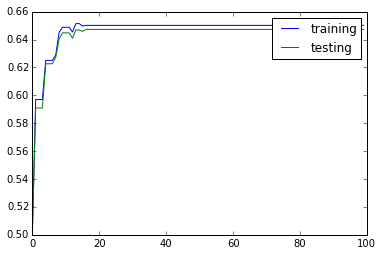

In [45]:
plt.plot(auc_train[:100], label="training")
plt.plot(auc_test[:100], label="testing")
plt.legend()

In [56]:
print "Test accuracy:", "%.2f" % (accuracy_test[-1] * 100) + '%'

Test accuracy: 65.01%
